https://www.kaggle.com/competitions/spaceship-titanic/overview

In [29]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
sys.path.insert(0, '../')
from utils import factorize, impute
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from ydata_profiling import ProfileReport
from pycaret.classification import setup, compare_models
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Preprocessing


In [34]:
train_data = pd.read_csv('Data/train.csv')
validation_data = pd.read_csv('Data/test.csv')
train_data['Transported'] = train_data['Transported'].astype('int64')
val_ids = validation_data['PassengerId']
train_ids = train_data['PassengerId']

entire_data = pd.concat([train_data, validation_data], axis=0, sort=False)


entire_data = factorize(entire_data, exclude = ['PassengerId', 'Transported'])

validation_data = entire_data[entire_data['PassengerId'].isin(val_ids)].drop('Transported',axis=1)

train_data = entire_data[entire_data['PassengerId'].isin(train_ids)]
print(validation_data['PassengerId'].head())

train_data = impute(train_data, exclude = ['PassengerId'])
validation_data = impute(validation_data, exclude=['PassengerId'])
print(validation_data['PassengerId'].head())


META_COLS = ['PassengerId', 'Name']

train_data = train_data.drop(META_COLS, axis=1)

train_y = train_data['Transported']
train_x = train_data.drop('Transported', axis=1)



0    0013_01
1    0018_01
2    0019_01
3    0021_01
4    0023_01
Name: PassengerId, dtype: object
0    0013_01
1    0018_01
2    0019_01
3    0021_01
4    0023_01
Name: PassengerId, dtype: object


Visualization

Text(0, 0.5, 'Count')

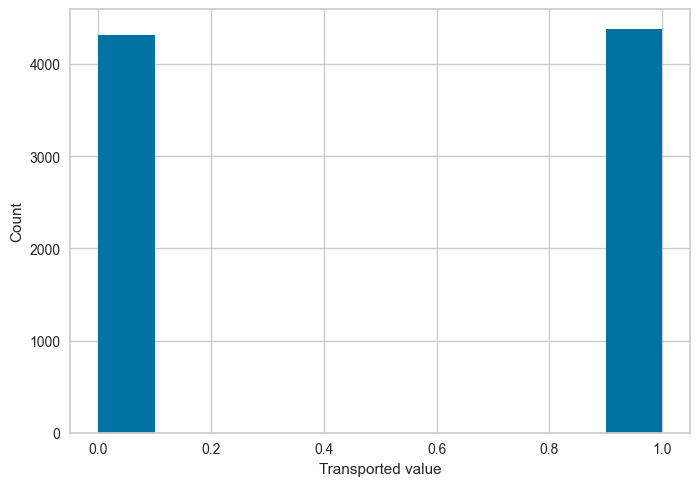

In [31]:
train_data['Transported'].astype(int).hist()
plt.xlabel('Transported value')
plt.ylabel('Count')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

ValueError: cannot reindex on an axis with duplicate labels

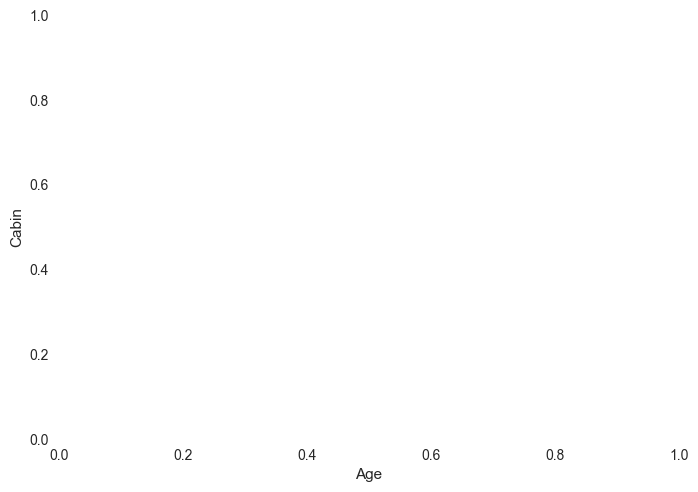

In [32]:
# generating a quick data report in HTML

profile = ProfileReport(train_data, title="Spaceship Titanic Profiling Report", explorative=True)

profile

Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(train_x, train_y, test_size=0.1, random_state=42)


lr = LogisticRegression()
#print(X_train.head(), y_train.unique())
lr.fit(X_train, y_train)


lr.score(X_train,y_train), lr.score(X_test, y_test)

(0.7696535855809792, 0.7551724137931034)

In [ ]:

def write_predictions(model,fp = 'submission.csv'):

    pred = model.predict(validation_data.drop(META_COLS ,axis=1))

    pred_df = pd.DataFrame()

    pred_df['PassengerId'] = validation_data['PassengerId']

    pred_df['Transported'] = list(map(bool,pred))

    pred_df.to_csv(fp,index=False)

In [ ]:

write_predictions(lr, fp='submission_lr.csv')

XGboost

In [ ]:
x_train, x_val, y_train0, y_val0 = train_test_split(X_train, y_train, test_size=0.1) 

print(len(y_train0), len(y_val0),len(y_train))
xgb = XGBClassifier()

xgb.fit(X_train, y_train)


train_pred = xgb.predict(X_train)
test_pred = xgb.predict(X_test)



accuracy_score(y_train, train_pred), accuracy_score(y_test, test_pred) 

7040 783 7823


(0.909625463377221, 0.7770114942528735)

Bayesian Optimization to reduce overfitting

In [ ]:

def init_xgb_from_params(space):
    
    for key, value in space.items():
        try:
            space[key] = int(space[key])
        except Exception:  
            continue

    clf=XGBClassifier(
                    **space)
    
    return clf

In [ ]:
RUN_HYPOPT = False

space={'max_depth': hp.quniform("max_depth", 3, 36, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators',50,500,50),
        'seed': 0,
        'objective': 'binary:logistic',
    }


def objective(space):
    
    clf  = init_xgb_from_params(space)
    evaluation = [( x_train, y_train0), ( x_val, y_val0)]
    
    clf.fit(x_train, y_train0,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK } # just optimziign accuracy for now


trials = Trials()

if RUN_HYPOPT:
    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials)
else:
    best_hyperparams = {'colsample_bytree': 0.5753966092225853,
                         'gamma': 3.3021835582533443, 
                         'max_depth': 6.0, 
                         'min_child_weight': 2.0, 
                         'n_estimators': 200.0, 
                         'reg_alpha': 81.0,
                           'reg_lambda': 0.20466227685256955}





In [ ]:
print(best_hyperparams)
xgb = init_xgb_from_params(best_hyperparams)

xgb.fit(X_train, y_train) # fit on ALL TRAIN DATA
test_pred = xgb.predict(X_test)
train_pred = xgb.predict(X_train)
print(accuracy_score(y_train, train_pred) ,accuracy_score(y_test, test_pred))
write_predictions(xgb,fp = 'submission_xgb.csv')


{'colsample_bytree': 0.5753966092225853, 'gamma': 3.3021835582533443, 'max_depth': 6.0, 'min_child_weight': 2.0, 'n_estimators': 200.0, 'reg_alpha': 81.0, 'reg_lambda': 0.20466227685256955}
0.772465805956794 0.764367816091954


PYCARET Kitchen sink approach

In [ ]:
s = setup(train_data,
          target = 'Transported',
          train_size = 0.9,
          session_id = 1,
          ignore_features = ['PassengerId', 'Cabin'],
          polynomial_features=True, 
        #   bin_numeric_features=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 
        #                         'Spa', 'VRDeck', 'GroupID', 'TotalBill', 'Cabin_num', 
        #                         'Spa_VR', 'RSVR'], 
          remove_outliers=True, 
          normalize=True, 
          fold=5, 
        #   categorical_features=['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side', 'Spent', 
        #                         'EurMar_no_spend', 'Cryo_spend'], 
          #keep_features=['CryoSleep', 'HomePlanet'], # HomePlanet added
          polynomial_degree=2, 
          transformation=True, # new
          group_features=['RoomService', 'FoodCourt', 'ShoppingMall', 
                                'Spa', 'VRDeck']
                                )
          
# top 3 models based on accuracy


base_model = compare_models(sort='Accuracy', fold=5)

,Description,Value
0,Session id,1
1,Target,Transported
2,Target type,Binary
3,Original data shape,"(8693, 12)"
4,Transformed data shape,"(8301, 72)"
5,Transformed train set shape,"(7431, 72)"
6,Transformed test set shape,"(870, 72)"
7,Ignore features,2
8,Numeric features,10
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7887,0.8689,0.8363,0.7659,0.7995,0.5771,0.5797,0.0880
rf,Random Forest Classifier,0.7827,0.8536,0.7769,0.7886,0.7827,0.5654,0.5656,0.1280
lightgbm,Light Gradient Boosting Machine,0.7827,0.8665,0.8145,0.7682,0.7906,0.5652,0.5663,0.0840
ada,Ada Boost Classifier,0.7789,0.8563,0.8393,0.7510,0.7927,0.5573,0.5614,0.0980
xgboost,Extreme Gradient Boosting,0.7785,0.8600,0.8020,0.7683,0.7848,0.5568,0.5574,0.0800
lda,Linear Discriminant Analysis,0.7699,0.8274,0.7777,0.7684,0.7729,0.5398,0.5399,0.0700
ridge,Ridge Classifier,0.7697,0.0000,0.7749,0.7694,0.7721,0.5393,0.5393,0.0680
et,Extra Trees Classifier,0.7665,0.8303,0.7525,0.7770,0.7644,0.5330,0.5334,0.1300
lr,Logistic Regression,0.7662,0.8233,0.7822,0.7604,0.7712,0.5323,0.5326,0.4580
qda,Quadratic Discriminant Analysis,0.7644,0.8261,0.7594,0.7699,0.7645,0.5288,0.5290,0.0840


In [ ]:
from pycaret.classification import tune_model
print(type(base_model))
base_model = tune_model(base_model, n_iter=50, fold=5, early_stopping=True, early_stopping_max_iters=5)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7802,0.8656,0.8325,0.7558,0.7923,0.5600,0.5630
1,0.7923,0.8767,0.8287,0.7746,0.8007,0.5844,0.5859
2,0.7898,0.8659,0.8401,0.7653,0.8010,0.5792,0.5821
3,0.7986,0.8739,0.8338,0.7812,0.8066,0.5970,0.5983
4,0.7922,0.8611,0.8236,0.7772,0.7998,0.5842,0.5852
Mean,0.7906,0.8686,0.8317,0.7708,0.8001,0.5810,0.5829
Std,0.0060,0.0058,0.0055,0.0092,0.0046,0.0120,0.0114


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
from pycaret.classification import predict_model
import numpy as np
# finding the best thresholds to classify 0 or 1 based on training data

from sklearn.metrics import accuracy_score

pred_train = predict_model(base_model, raw_score=True)

def find_best_threshold(y_true, probabilities):
    thresholds = np.linspace(0, 1, 1000)  # Generate 100 threshold values between 0 and 1
    best_threshold = None
    best_accuracy = 0

    for threshold in thresholds:
        y_pred = (probabilities >= threshold).astype(int)
        accuracy = accuracy_score(y_true, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold, best_accuracy

best_threshold, best_accuracy = find_best_threshold(pred_train.Transported.astype('int'), 
                                                    pred_train['prediction_score_1'])

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best Accuracy: {best_accuracy:.3f}")


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7920,0.8874,0.8470,0.7649,0.8039,0.5836,0.5870


Best Threshold: 0.585
Best Accuracy: 0.802


In [ ]:
# train the whole df_train dataset
from pycaret.classification import *
base_model = finalize_model(base_model)

# predict on new data (df_test)

pred_test = predict_model(base_model, data = validation_data, probability_threshold=0.5, raw_score=True)

pred_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,prediction_label,prediction_score_0,prediction_score_1
0,1301.0,1.0,1.0,6560.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,8473.0,1,0.3277,0.6723
1,1801.0,1.0,0.0,6561.0,0.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,8474.0,0,0.9170,0.0830
2,1901.0,0.0,1.0,6562.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,8475.0,1,0.0477,0.9523
3,2101.0,0.0,0.0,6563.0,0.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,8476.0,1,0.1834,0.8166
4,2301.0,1.0,0.0,6564.0,0.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,8477.0,1,0.4775,0.5225


In [ ]:
# putting the submission together

Submission = pd.DataFrame(data={'PassengerId':pred_test['PassengerId'], 'Transported':[True if x > 0 else False for x in pred_test['prediction_label']]})

# saving the predictions in a csv file for submission

Submission.to_csv('submission_pycaret_gb.csv', index=False)

Submission.head()

,PassengerId,Transported
0,1301.0,True
1,1801.0,False
2,1901.0,True
3,2101.0,True
4,2301.0,True
